# **Importing the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem.porter import *
import string  
import seaborn as sns

# **Data Exploration and Information**

In [2]:
train_df = pd.read_csv('C:/Idris/Ecole/2A/Tweet Sentiment Analysis/train_E6oV3lV.csv')
test_df = pd.read_csv('C:/Idris/Ecole/2A/Tweet Sentiment Analysis/test_tweets_anuFYb8.csv')
print('shape of the train dataset',train_df.shape)
print('shape of the test dataset',test_df.shape)

shape of the train dataset (31962, 3)
shape of the test dataset (17197, 2)


In [6]:
# let's have a look at our training dataset
pd.set_option("display.max_colwidth", 300) #to make sure we can see the whole text
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [7]:
# these were all labeled as non racist/sexist, let's now see tweets which are labeled as such
train_df[train_df['label'] == 1].head()


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


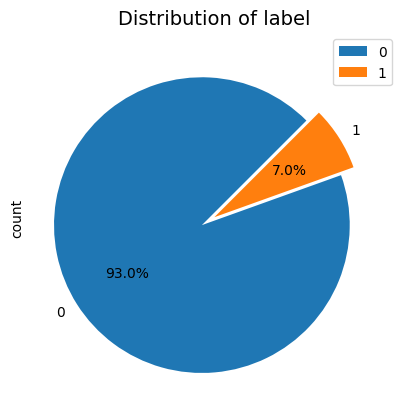

In [8]:
# let's have a look at the distribution of the output feature "label" in the training dataset
train_df['label'].value_counts().plot.pie(explode=[0.1,0],autopct='%3.1f%%', legend=True,startangle=45)
plt.title('Distribution of label',size=14)
plt.show()

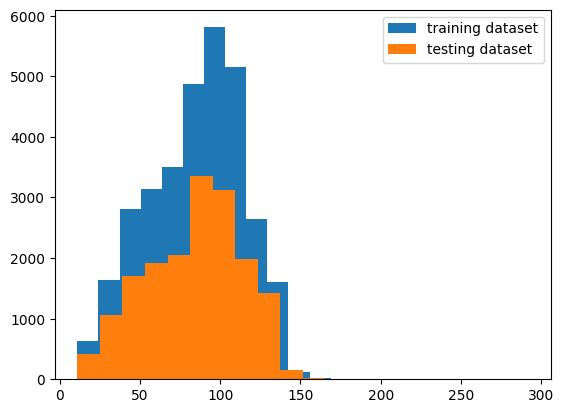

In [9]:
# and the distribution of length of the tweets in both training and testing datasets
plt.hist(train_df.tweet.str.len(), bins=20, label='training dataset')
plt.hist(test_df.tweet.str.len(), bins=20, label='testing dataset')
plt.legend()
plt.show()

**Interpretation**
- There's a lot of useless characters no matter whether the tweet is racist/sexist or not
- Our data is unbalanced: in the training dataset, only 7% of the tweets are labeled as racist/sexist
- There's a lot of words in each tweet of each dataset, thus we will clean the raw text

# **Data Preprocessing**

We will clean the data now. To do so, let's :
1) Remove twitter handles
2) Remove punctuations
3) Remove numbers
4) Remove special and non-english characters
5) Remove short words
6) Normalize the data


In [10]:
# first we will combine training and testing dataset to preprocess the data
combi_df = pd.concat([train_df, test_df], ignore_index=True, sort=True)

In [11]:
# and now we can clean the data:

# remove twitter handles
combi_df['tidy_tweet'] = combi_df['tweet'].str.replace(r'@[\w]*', ' ', regex=True)
# remove punctuations ",.;:?!#
combi_df['tidy_tweet'] = combi_df['tidy_tweet'].str.replace(r'[,.;:?!#]', ' ', regex=True)
# remove numbers
combi_df['tidy_tweet'] = combi_df['tidy_tweet'].str.replace(r'[0-9]+', ' ', regex=True)
# remove non-ASCII characters
combi_df['tidy_tweet'] = combi_df['tidy_tweet'].str.replace(r'[^\x00-\x7F]+', ' ', regex=True)
# remove extra spaces
combi_df['tidy_tweet'] = combi_df['tidy_tweet'].str.replace(r'\s+', ' ', regex=True).str.strip()
# remove short words, length <= 3 is regarded as short word
combi_df['tidy_tweet'] = combi_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
# tokenization
combi_df['tidy_tweet'] = combi_df['tidy_tweet'].apply(lambda x: x.split())
# stemming
stemmer = PorterStemmer()
tokenized_tweet = combi_df['tidy_tweet'].apply(lambda x: [stemmer.stem(word) for word in x])

In [12]:
# let's have a look at our tokenized data
tokenized_tweet.head()

0                                    [when, father, dysfunct, selfish, drag, kid, into, dysfunct]
1    [thank, lyft, credit, can't, caus, they, don't, offer, wheelchair, van, disapoint, getthank]
2                                                                         [bihday, your, majesti]
3                                                                 [model, love, take, with, time]
4                                                                     [factsguid, societi, motiv]
Name: tidy_tweet, dtype: object

In [13]:
# and now we put back the tokens together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi_df['tidy_tweet'] = tokenized_tweet
combi_df.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank lyft credit can't caus they don't offer wheelchair van disapoint getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi motiv


# **Data Analysis**

This is actually the same as Data Exploration and Information, nevertheless here we are going to analyze the cleaned data.

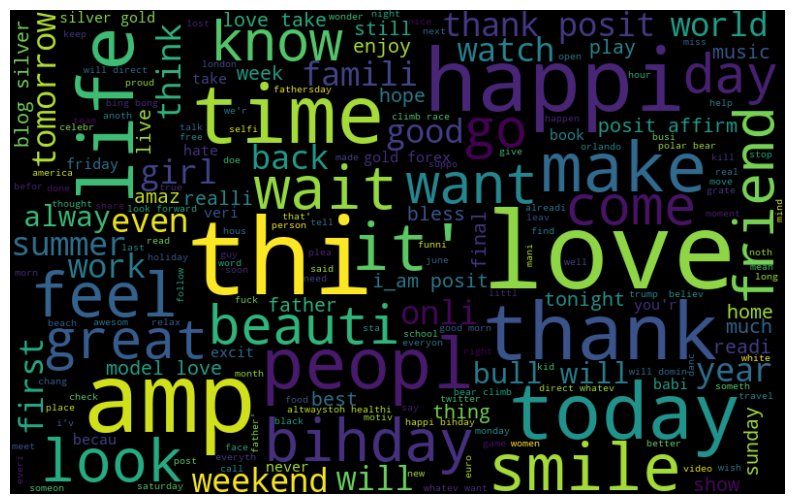

In [14]:
# let's visualize the most common words used in the tweets
random_state = 4320 #for reproductibility
all_words = ' '.join([word for word in combi_df['tidy_tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=random_state, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

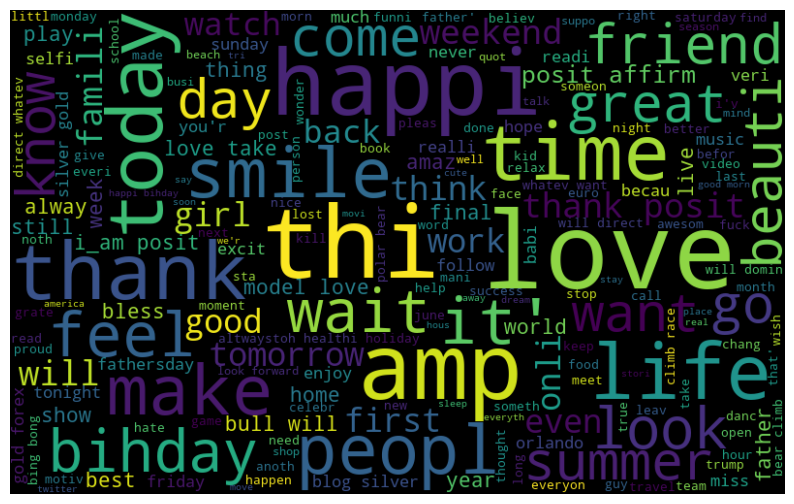

In [15]:
# let's visualize the most common words used in the non racist/sexist tweets
normal_words =' '.join([word for word in combi_df['tidy_tweet'][combi_df['label'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=random_state, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

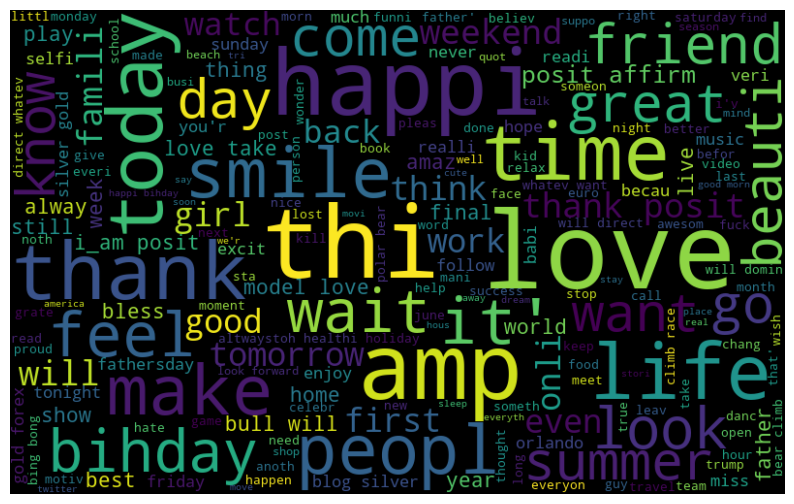

In [16]:
# let's visualize the most common words used in the  racist/sexist tweets
racist_and_sexist_words =' '.join([word for word in combi_df['tidy_tweet'][combi_df['label'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=random_state, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Interpretation**
- The most common words used in every tweet (i.e. both racist/sexist tweets and those which are not) are compatible with the sentiment, non-racist/sexists tweets 
- Most of the frequent words in non racist/sexist tweet are compatible with the sentiment, i.e, non-racist/sexists tweets
- Most of the words in racist/sexist tweet have negative connotations
- It seems we have a  good text data to work on

# **Data Preparation**

**Let's train a Word2Vec model on our data.**

In [17]:
import gensim
length_of_embeddings = 200 #number of features
tokenized_tweet = combi_df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
        tokenized_tweet,
        vector_size=length_of_embeddings,
        window=5, #context window size
        min_count=2, #ignore all words with total frequency lower than 2
        sg = 1, #1 for skip-gram model
        hs = 0,
        negative = 10, #for negative sampling
        workers= 8, #no. of cores
        seed = random_state
    )

model_w2v.train(tokenized_tweet,total_examples=len(combi_df['tweet']),epochs=20)

(6491854, 7595980)

In [18]:
# let's check how well our model works
model_w2v.wv.most_similar(positive="food")

[('foodporn', 0.565795361995697),
 ('hotdog', 0.5633784532546997),
 ('foodi', 0.5361328721046448),
 ('delici', 0.5341565012931824),
 ('foodblogg', 0.5221232771873474),
 ('instafood', 0.5141969919204712),
 ('buffet', 0.5031185746192932),
 ('guildford', 0.4912201762199402),
 ('easesthepain', 0.4891490340232849),
 ('pasta', 0.4884074628353119)]

In [19]:
# let's check how well our model works
model_w2v.wv.most_similar(positive='trump')

[('dumptrump', 0.5710092782974243),
 ('donald', 0.5468549132347107),
 ('co-chairman', 0.5303094983100891),
 ('won-they', 0.5262250304222107),
 ('presidentelect', 0.5242879986763),
 ('trumpleak', 0.5225762128829956),
 ('con', 0.5223395228385925),
 ('trumptrain', 0.522041916847229),
 ('bernieorbust', 0.5193638205528259),
 ('irrefut', 0.5184589624404907)]

Now let's convert our result to Word2Vec embeddings.

Since our data contains tweets and not just words, we create vector representation for an entire tweet. To do this, we take the mean of all the word vectors present in the tweet, and then we repeat the same process for all the tweets in our data and obtain their vectors.

We will u the function word_vector written below toto create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [20]:
def word_vector(tokens, length_of_embeddings=200):
        vec = np.zeros(length_of_embeddings).reshape((1,length_of_embeddings))
        count = 0
        for word in tokens:
            try:
                vec += model_w2v.wv[word].reshape((1,length_of_embeddings))
                count += 1.
            except KeyError: #handling the case where the token is not in vocabulary
                continue
        if count != 0:
            vec /= count
        return vec

In [21]:
#tokenized_tweet has been trained by model_w2v, now we apply word_vector to convert tokenized_tweet into Word2Vec embeddings (numpy array)
embeddings = np.array([word_vector(tokens,length_of_embeddings) for tokens in tokenized_tweet])
embeddings = np.squeeze(embeddings) #the dimensions being (49159, 1, 200), we make it so embeddings' dimension is (49159, 200)
# store the embeddings (numpy array) in the wordvec_df (pandas dataframe)
wordvec_df = pd.DataFrame(embeddings)
wordvec_df.shape

(49159, 200)

# **SVM Model**

In [22]:
# extracting train and test w2v features 
train_w2v = wordvec_df.iloc[:31962,:] 
test_w2v = wordvec_df.iloc[31962:,:]
# split the dataset with 70% data as a training set and 30% as a testing set
xtrain_w2v, xtest_w2v, ytrain, ytest = train_test_split(train_w2v, train_df['label'], random_state=random_state, test_size=0.3)

In [23]:
from sklearn.svm import SVC
# create a svm classifier with a degree 4 polynomial kernel
clf = SVC(kernel='poly', degree=4, random_state=random_state)
# train the model using the training sets
clf.fit(xtrain_w2v, ytrain)
# predict the response for test dataset
ypred = clf.predict(xtest_w2v)
# calculation of the metrics
f1s = metrics.f1_score(ytest,ypred)
mcc = metrics.matthews_corrcoef(ytest,ypred)
print('F1-score:',f1s)
print('MCC:',mcc)

F1-score: 0.568
MCC: 0.5922643851762938


**Interpretation**
- Our model provides acceptable performances, let's try to tune it

First, we'll stick with the SVM model and check which is the best degree for the polynomial kernel.
I initially chose to fix the degree of the polynom as 4.
Indeed, we have identified some complexity in the data due to negative sentiment in hateful tweets, thus I thought higher degrees could help capture these nuances better.

In [24]:
# initialize variables to track the best scores
best_f1s = 0
best_mcc = 0
best_degree = None

# iterate over the specified degrees
for degree in [2, 3, 4]:
    clf = SVC(kernel='poly', degree=degree, random_state=random_state)
    clf.fit(xtrain_w2v, ytrain)
    ypred = clf.predict(xtest_w2v)
    f1s = metrics.f1_score(ytest, ypred)
    mcc = metrics.matthews_corrcoef(ytest, ypred)
    
    # print the results for the current degree
    print(f'Degree: {degree}, F1-score: {f1s}, MCC: {mcc}')
    
    # update the best scores if the current F1 score is better
    if f1s > best_f1s:
        best_f1s = f1s
        best_mcc = mcc
        best_degree = degree

# print the best results
print(f'Best Degree: {best_degree}, Best F1 Score: {best_f1s}, Best MCC: {best_mcc}')

Degree: 2, F1-score: 0.5694581280788177, MCC: 0.5879562825562672
Degree: 3, F1-score: 0.5831702544031311, MCC: 0.6007458080888852
Degree: 4, F1-score: 0.568, MCC: 0.5922643851762938
Best Degree: 3, Best F1 Score: 0.5831702544031311, Best MCC: 0.6007458080888852


**Interpretation**
- We found the best degree is actually degree 3.
- This may be due to overfitting: a higher degree polynomial (like degree 4) can lead to a more complex decision boundary because it captures noise and outliers.

# **Extreme Gradient Boosting (XGBoost)**

In [25]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xtest_w2v)
f1s = metrics.f1_score(ytest, prediction)
mcc = metrics.matthews_corrcoef(ytest, prediction)
print('F1-score:', f1s)
print('MCC:', mcc)

F1-score: 0.6654676258992805
MCC: 0.66541224727319


**Interpretation**
- Our set being inbalanced (only 7% of every tweet in the training dataset are classified as racist/sexist), our F1-score of 66,5% is good
- Our MCC of 66,5% is also good

# **Conclusion**

- For the SVM model, we found that the optimal polynomial kernel degree was 3, resulting in a Best F1-Score of 58,3% and a Best MCC of 60,0%
- These scores reflect reasonable performance in the classification task
- Given the imbalanced nature of our dataset — where only 7% of the tweets are classified as racist or sexist — our XGBoost model achieved an F1-score of 66.5% and a MCC of 66.5%

- These metrics indicate a pretty good performance